In [ ]:
!pip install CoolProp

import pandas as pd
import CoolProp as CP
import matplotlib.pyplot as plt
import numpy as np
from CoolProp.CoolProp import PropsSI

In [ ]:
# LOAD IN DATA
df = pd.read_csv('/content/sample_data/refrig_data.csv')

press = 6894.76* df.iloc[:, 2:6].values  #Pa
temp = 273.15+df.iloc[:, 6:15].values   #Kelvin
current = df.iloc[:, 15:18].values      #amps
mass_flow = 0.00755985241260484*df.iloc[:, 18:19].values    #kg/s
voltage = df.iloc[:, 19:20].values      #volts

# PROCESS DATA
T1 = temp[:, 0]   #state 1
p1 = press[:, 0]
T2 = temp[:, 1]   #state 2
p2 = press[:, 1]
T4 = temp[:, 3]   #state 3
p3 = press[:, 2]
T6 = temp[:, 5]   #state 4
p4 = press[:, 3]
current_1 = current[:, 0]
current_2 = current[:, 1]
current_3 = current[:, 2]
mass_flow = mass_flow[:, 0]
voltage = voltage[:, 0]

# DEFINE VARIABLES

h1 = []
s1 = []
h2 = []
s2 = []
s22 = []
h2_f = []
h2_g = []
s2_f = []
s2_g = []
x = []
h3 = []
s3 = []
h4 = []
s4 = []
s44 = []

# SOLVE FOR H AND S

#find h1, s1 (saturated liquid)
for t in T1:
  h1.append(PropsSI('H','T',t,'Q',0,'R12')) #J/kg
  s1.append(PropsSI('S','T',t,'Q',0,'R12')) #J/kg-K

#h1 = h2, use temp to find hg and hf at state 2
h2 = h1
for T in T2:
  h2_g.append(PropsSI('H','T',T,'Q',1,'R12'));  #J/kg
  h2_f.append(PropsSI('H','T',T,'Q',0,'R12'));
  s2_g.append(PropsSI('S', 'T', T, 'Q',1,'R12'))  #J/kg-K
  s2_f.append(PropsSI('S','T', T, 'Q',0,'R12'))

#use h2,hg,hf to find x, use x to find s2
for h,hg,hf in zip(h2,h2_g,h2_f):
  x.append((h-hf)/(hg-hf))

for q,t in zip(x,T2):
  s2.append(PropsSI('S','T',t,'Q',q,'R12'))

#find h3,s3 (superheated vapor)
for T,p in zip(T4,p3):
  h3.append(PropsSI('H','T',T,'P',p,'R12'))
  s3.append(PropsSI('S','T',T,'P',p,'R12'))

#find h4,s4 (superheated vapor)
for T,p in zip(T6,p4):
  h4.append(PropsSI('H','T',T,'P',p,'R12'))
  s4.append(PropsSI('S','T',T,'P',p,'R12'))

#extra points to make graphs pretty
for T in T1:
  s44.append(PropsSI('S','T',T,'Q',1,'R12'))
for T in T2:
  s22.append(PropsSI('S','T',T,'Q',1,'R12'))

# CALCULATE IDEAL & REAL CYCLE

# IDEAL
h4_ideal = []
s4_ideal = s3
for p,s in zip(p4,s3):
  h4_ideal.append(PropsSI('H', 'S', s, 'P', p, 'R12'))  # J/kg
# REAL
h4_real = []
s4_real = []
T6_real = []

for V,I,m in zip(voltage,current_2,mass_flow):
  h4_real.append((V*I)/m)
h4_real = np.array(h4_real)+h3
for h,p in zip(h4_real,p4):
  s4_real.append(PropsSI('S','H',h,'P',p,'R12'))
  T6_real.append(PropsSI('T','H',h,'P',p,'R12'))


# CALCULATE REAL/EXP CYCLE

RC = []
cop_ideal = []
cop_exp = []
cop_real = []

# RC
for H2,H3,m in zip(h2,h3,mass_flow):
  RC.append(m*((H3-H2)/(H2)))
# COP ideal
for H2,H3,H4 in zip(h2,h3,h4_ideal):
  cop_ideal.append((H3-H2)/(H4-H3))
# COP experimental
for H2,H3,H4 in zip(h2,h3,h4):
  cop_exp.append((H3-H2)/(H4-H3))
# COP real
for H2,H3,H4 in zip(h2,h3,h4_real):
  cop_real.append((H3-H2)/(H4-H3))

print (RC)
print (cop_exp)
print (cop_real)
print (cop_ideal)

[0.0012447424818932842, 0.002144351252031012, 0.003123021515683828, 0.004677290653663874, 0.004641715014659663, 0.004465282378528656, 0.004857890921409939, 0.004371044578045458, 0.00470665944602985]
[32.1206423299114, 9.338708654757113, 4.8181964599104, 3.1172428290413, 3.1285174283001416, 3.1310793825301824, 2.9509578218077124, 2.500072624149428, 2.7916737407506607]
[0.4546690871545132, 0.7451684315591326, 0.9958975341926806, 1.2560308144501935, 1.2485431627758619, 1.1810463876221369, 1.284897426772105, 1.0986217533460376, 1.246459138714815]
[1.4737611789393774, 2.161263180588714, 2.7395585454613345, 3.238806403503687, 3.250369326013304, 2.963835063615721, 3.2949420527397635, 2.9163226860885443, 3.2428008613634716]


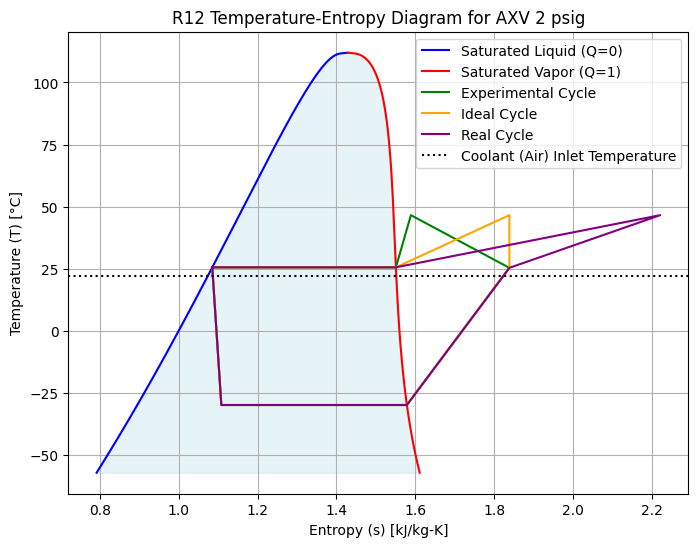

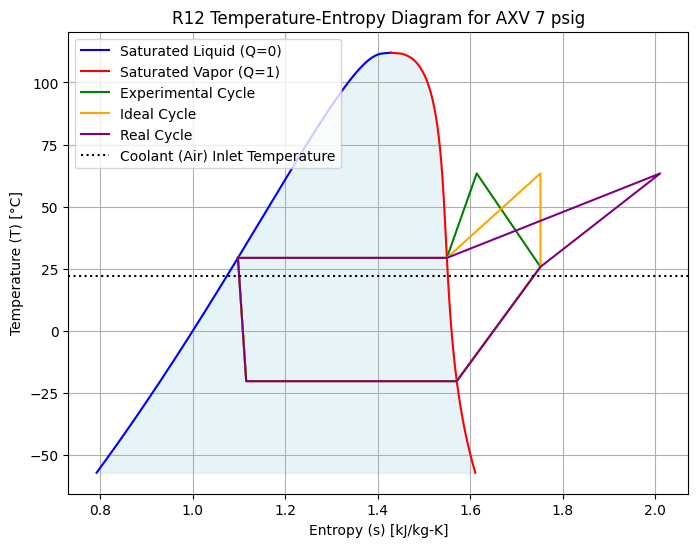

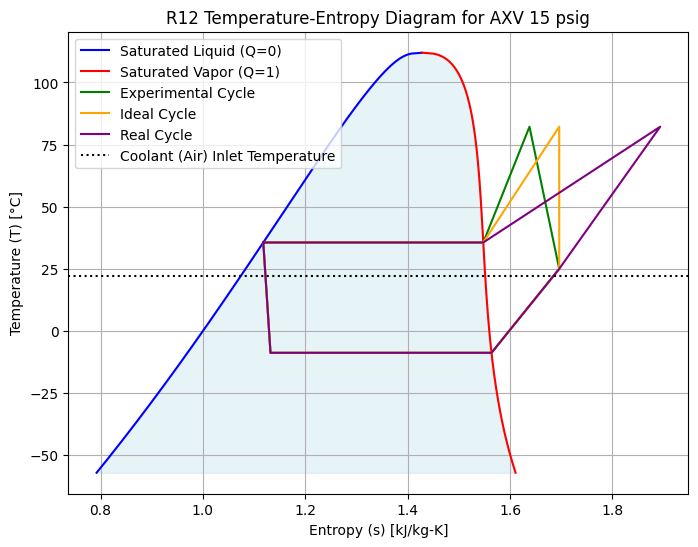

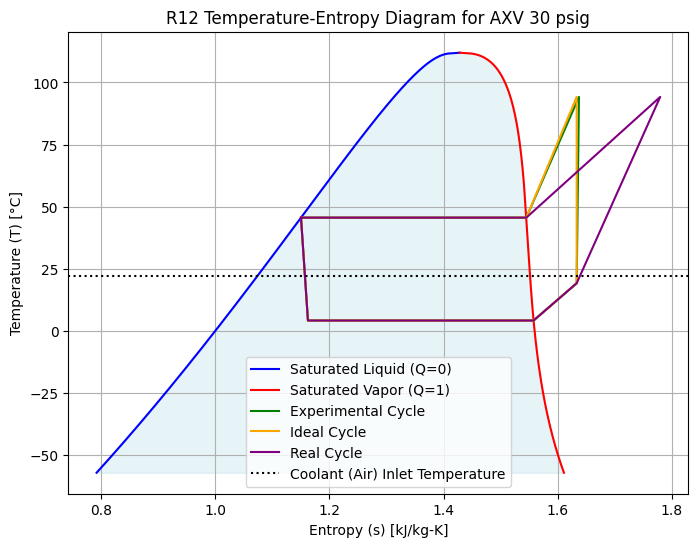

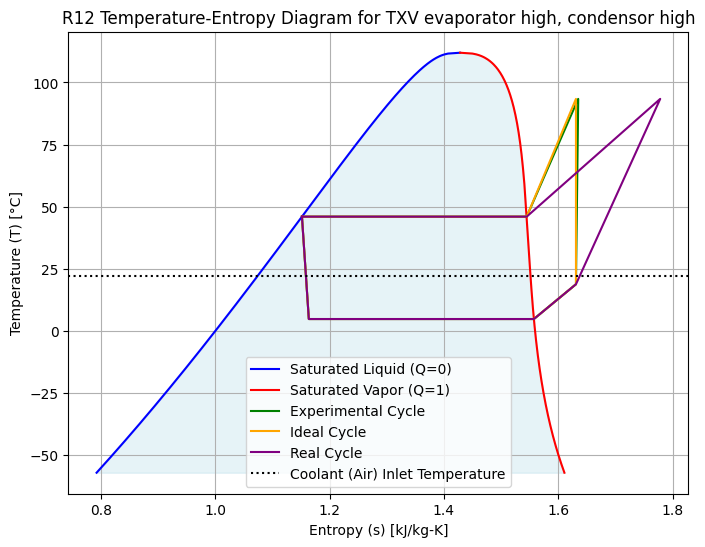

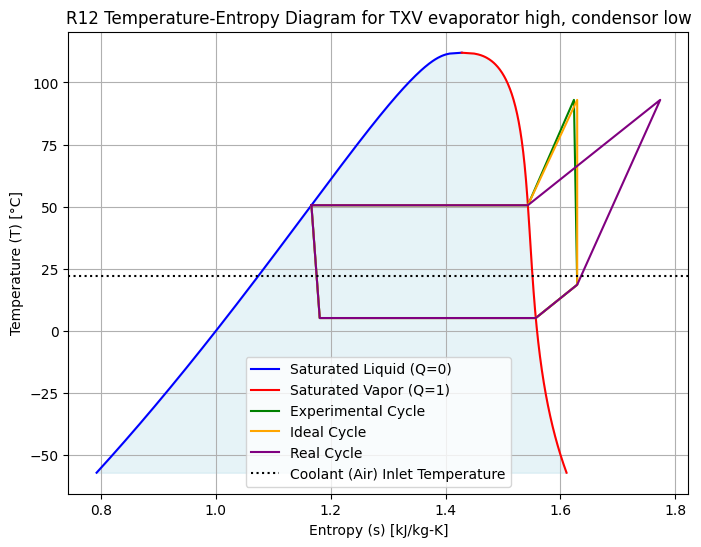

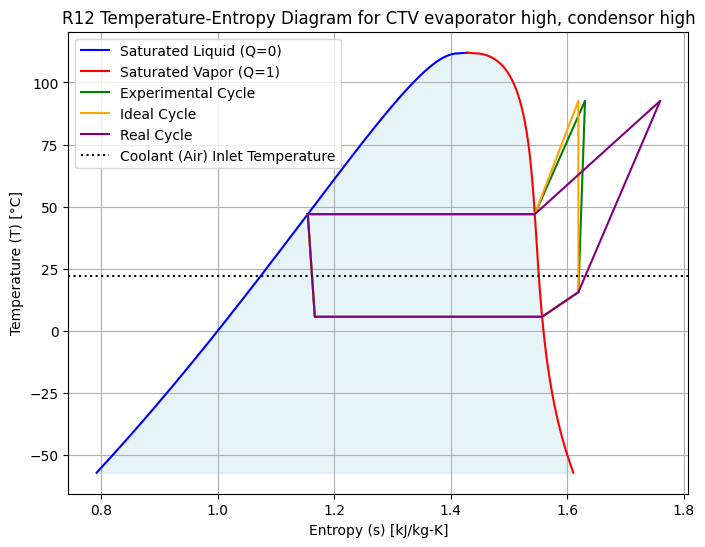

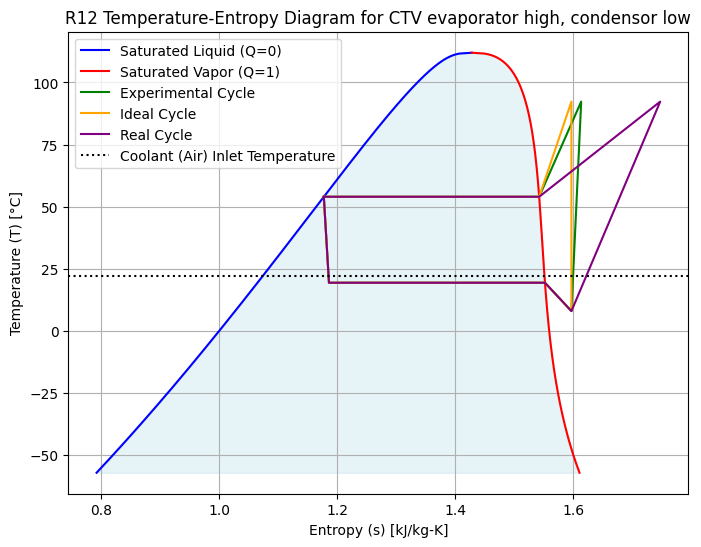

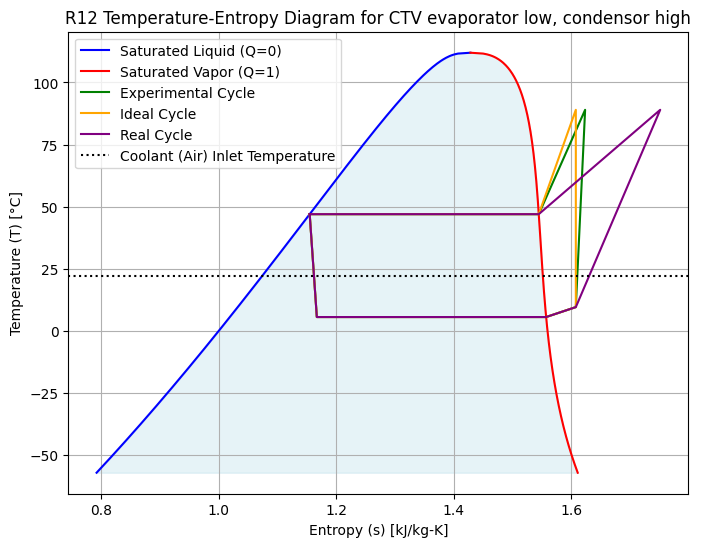

In [ ]:
# PLOT T-S DIAGRrAM

# setup for graphing T-s diagram
# Generate a range of temperatures for the saturation dome
T_min = PropsSI('Tmin', 'R12')                  # Minimum temperature
T_crit = PropsSI('Tcrit', 'R12')                # Critical temperature
temperatures = np.linspace(T_min+100, T_crit, 500)  # 500 points between Tmin and Tcrit

# array of titles for T-s diagrams
titles = ["AXV 2 psig","AXV 7 psig","AXV 15 psig", "AXV 30 psig",\
          "TXV evaporator high, condensor high", "TXV evaporator high, condensor low",\
          "CTV evaporator high, condensor high", "CTV evaporator high, condensor low",\
          "CTV evaporator low, condensor high"]

def plot_ts_diagram(i):

  #plot s1-s4 against saturation dome in T-s plot
  s_arr = np.array([s1[i],s2[i],s22[i],s3[i],s4[i],s44[i],s1[i]])/1000
  s_ideal_arr = np.array([s1[i],s2[i],s22[i],s3[i],s4_ideal[i],s44[i],s1[i]])/1000
  s_real_arr = np.array([s1[i],s2[i],s22[i],s3[i],s4_real[i],s44[i],s1[i]])/1000
  T_arr = np.array([T1[i],T2[i],T2[i],T4[i],T6[i],T1[i],T1[i]])-273.15

  s_liquid = []
  s_vapor = []
  T_liquid = []
  T_vapor = []

  # Loop through temperatures and calculate properties
  for T in temperatures:
      try:
          # Saturated liquid properties (Q = 0)
          s_liq = PropsSI('S', 'T', T, 'Q', 0, 'R12')  # Entropy (J/kg-K)
          s_liquid.append(s_liq)
          T_liquid.append(T)

          # Saturated vapor properties (Q = 1)
          s_vap = PropsSI('S', 'T', T, 'Q', 1, 'R12')  # Entropy (J/kg-K)
          s_vapor.append(s_vap)
          T_vapor.append(T)
      except ValueError:
          # Skip invalid points (e.g., below triple point)
          continue

  # Convert lists to numpy arrays for plotting
  s_liquid = np.array(s_liquid) / 1000  # Convert to kJ/kg-K for better visualization
  s_vapor = np.array(s_vapor) / 1000    # Convert to kJ/kg-K
  T_liquid = np.array(T_liquid) - 273.15  # Convert to Celsius
  T_vapor = np.array(T_vapor) - 273.15    # Convert to Celsius

  # Plot the saturation dome
  plt.figure(figsize=(8, 6))
  plt.plot(s_liquid, T_liquid, label="Saturated Liquid (Q=0)", color='blue')
  plt.plot(s_vapor, T_vapor, label="Saturated Vapor (Q=1)", color='red')
  plt.fill_betweenx(T_liquid, s_liquid, s_vapor, color='lightblue', alpha=0.3)
  plt.plot(s_arr,T_arr, label="Experimental Cycle", color='green')
  plt.plot(s_ideal_arr,T_arr, label="Ideal Cycle", color='orange')
  plt.plot(s_real_arr,T_arr, label="Real Cycle", color='purple')
  plt.axhline(y=22.2, color='black', linestyle=':', label="Coolant (Air) Inlet Temperature")
  plt.xlabel("Entropy (s) [kJ/kg-K]")
  plt.ylabel("Temperature (T) [°C]")
  plt.title(f"R12 Temperature-Entropy Diagram for " + titles[i])
  plt.legend(loc="best")
  plt.grid(True)
  plt.savefig(titles[i]+'.png')
  plt.show()

for i in range(9):
  plot_ts_diagram(i)

<ipython-input-9-8668ef0f11c9>:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "c" (-> color=(0.0, 0.75, 0.75, 1)). The keyword argument will take precedence.
  plt.plot(s_liquid, enthalpy_sat, 'c', label='Saturated Liquid', color ='red')
<ipython-input-9-8668ef0f11c9>:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "c" (-> color=(0.0, 0.75, 0.75, 1)). The keyword argument will take precedence.
  plt.plot(s_vapor, enthalpy_sat, 'c', label='Saturated Vapor',color = 'blue')


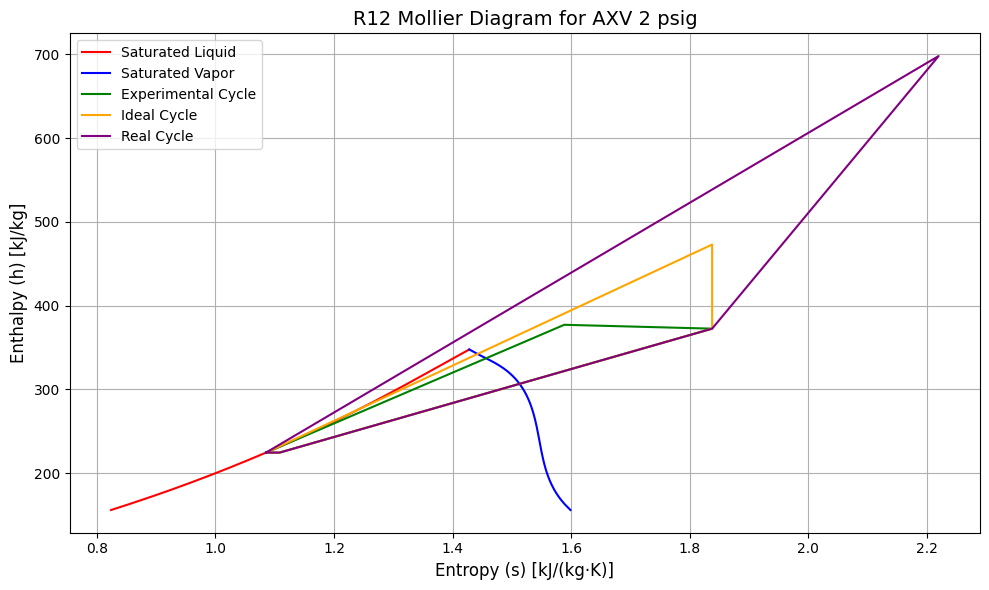

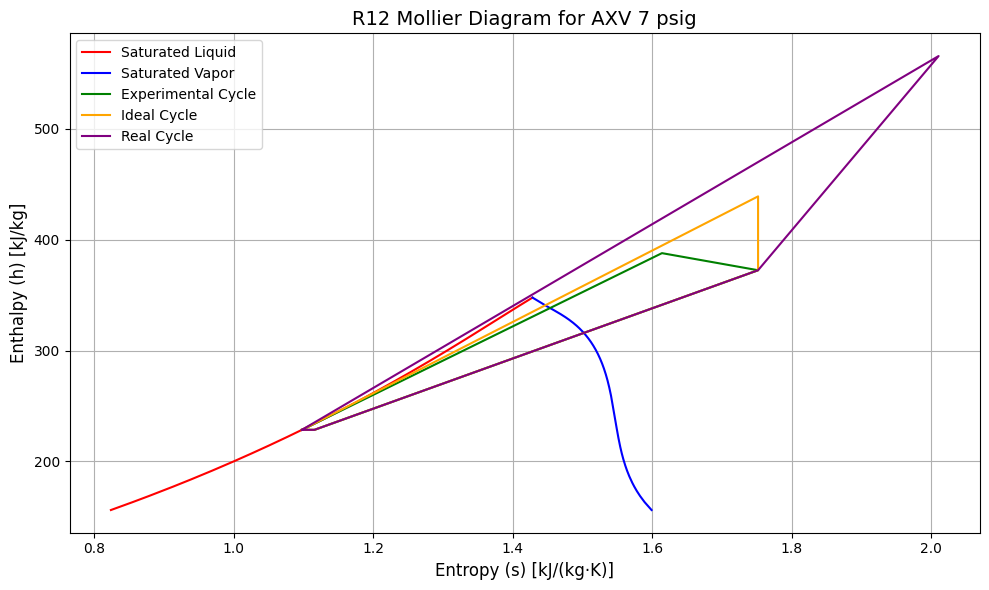

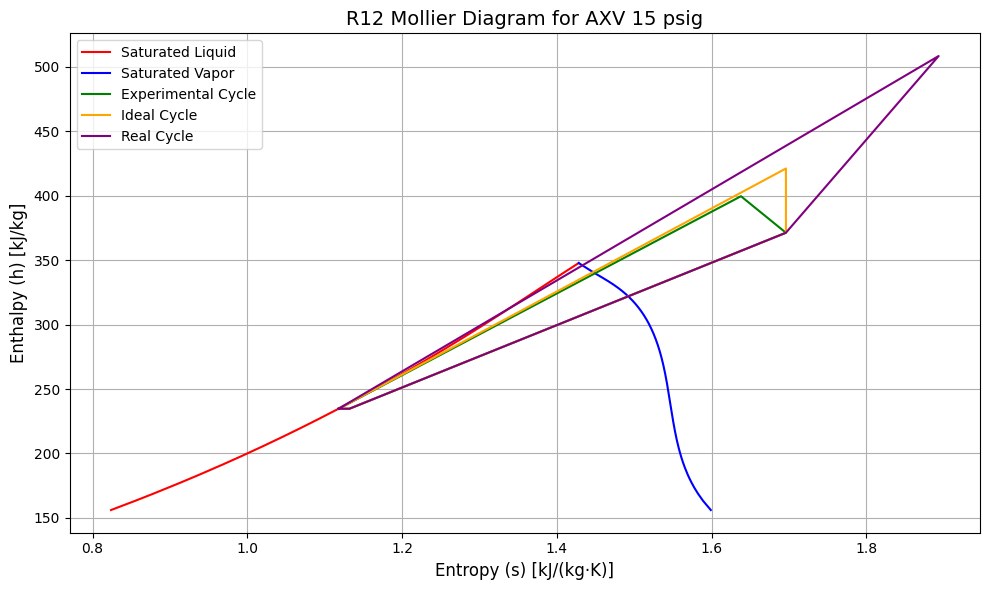

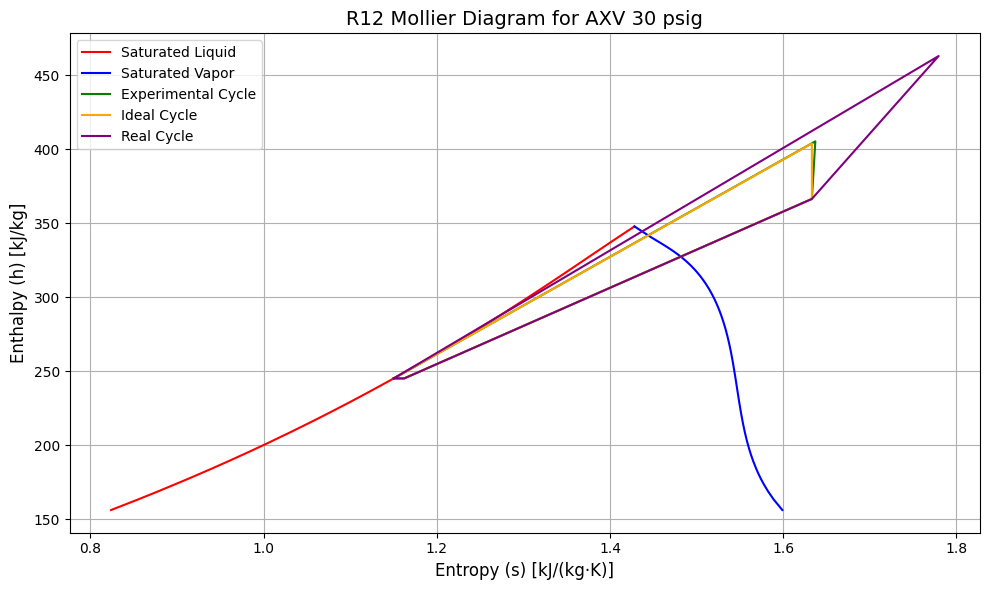

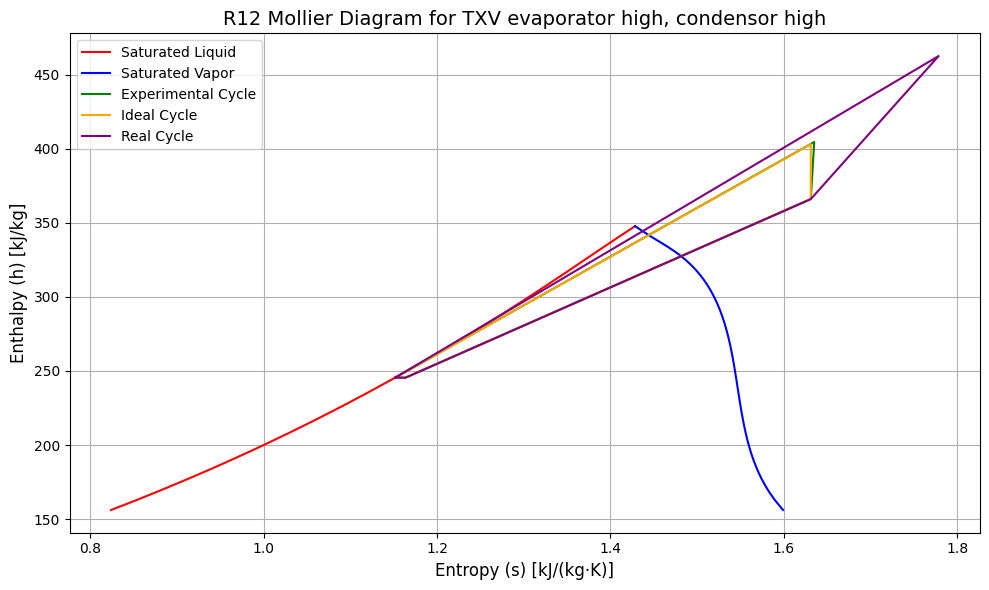

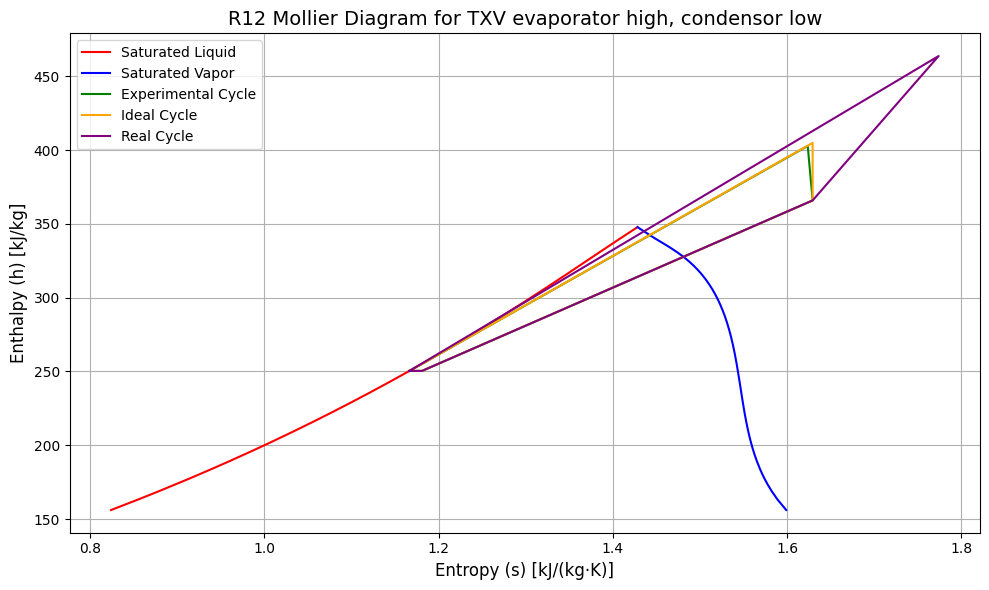

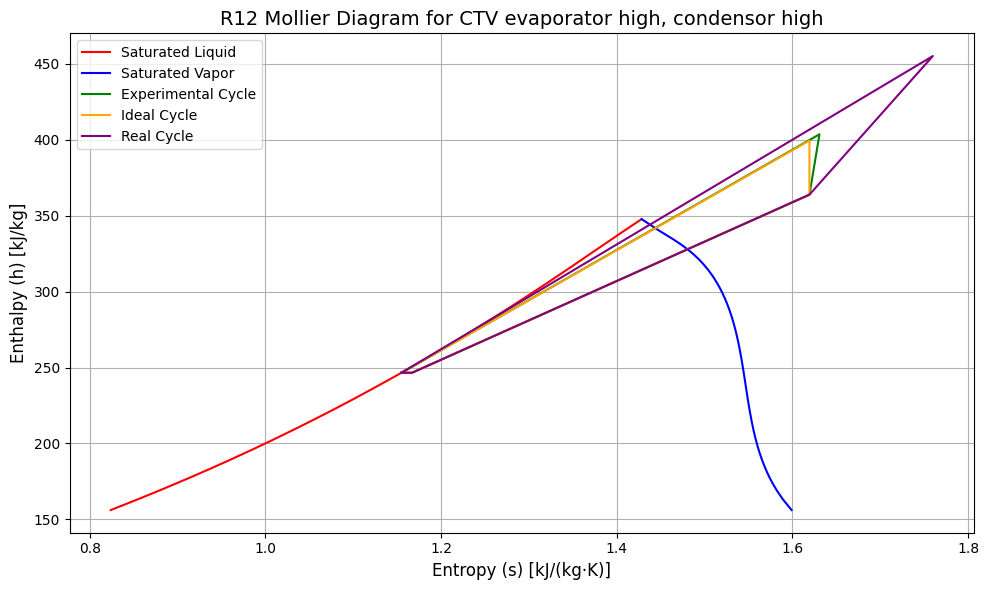

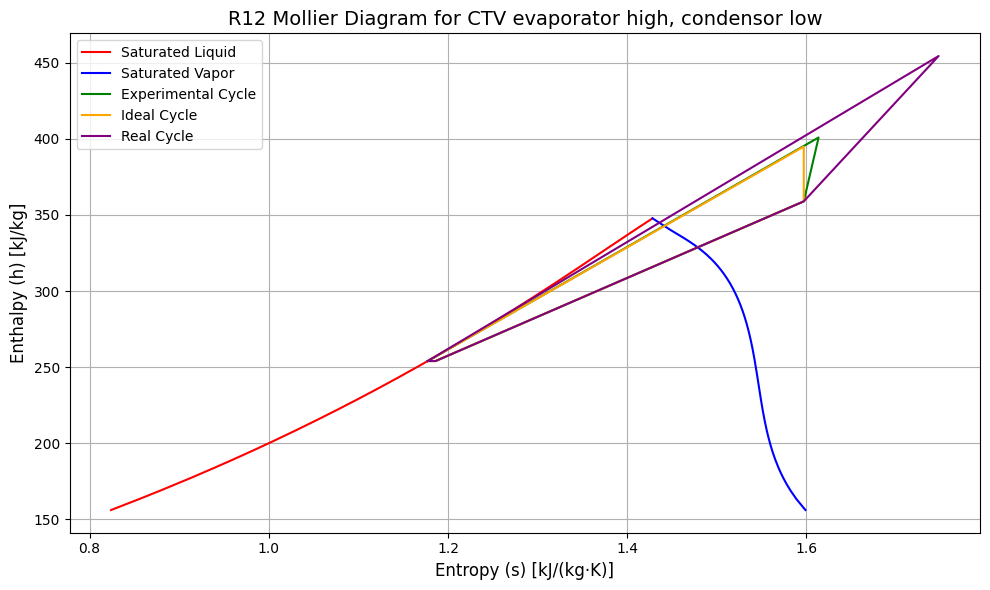

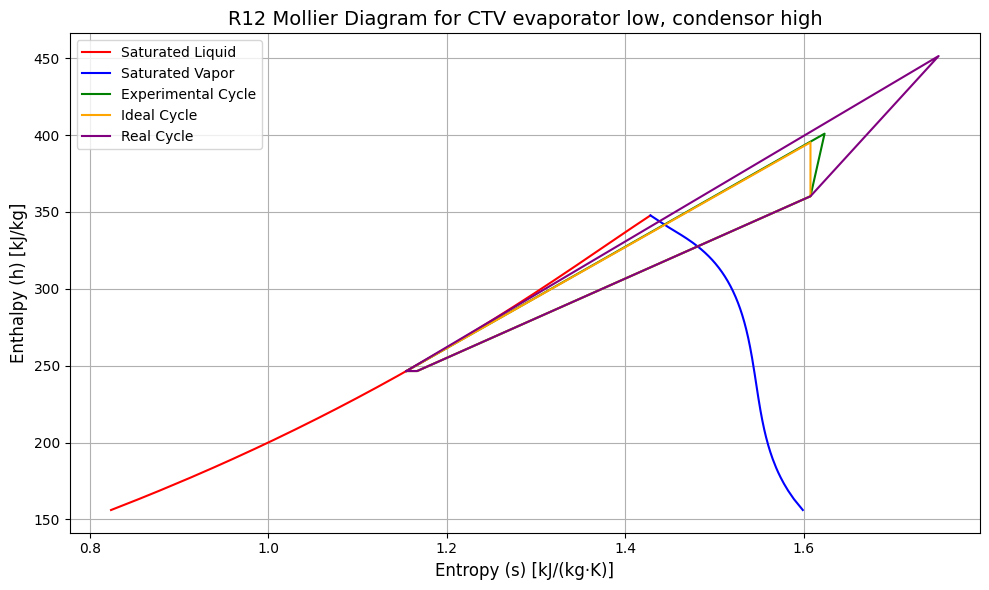

In [ ]:
#plot s1-s4 against h1-h4 in h-s plot
def plot_mollier_diagram(i):

    s_arr = np.array([s1[i],s2[i],s3[i],s4[i],s1[i]])/1000  #kj/kg-K
    h_arr = np.array([h1[i],h2[i],h3[i],h4[i],h1[i]])/1000  #kj/kg
    s_ideal_arr = np.array([s1[i],s2[i],s3[i],s4_ideal[i],s1[i]])/1000
    h_ideal_arr = np.array([h1[i],h2[i],h3[i],h4_ideal[i],h1[i]])/1000
    s_real_arr = np.array([s1[i],s2[i],s3[i],s4_real[i],s1[i]])/1000
    h_real_arr = np.array([h1[i],h2[i],h3[i],h4_real[i],h1[i]])/1000

    # Generate a range of temperatures in Kelvin
    pressures= np.linspace(PropsSI('Pcrit', 'R12') * .01, PropsSI('Pcrit', 'R12'), 200)

    # Lists to store saturation dome data
    enthalpy_sat = []
    s_liquid = []  # Entropy of saturated liquid
    s_vapor = []   # Entropy of saturated vapor

    # Loop over the temperature range to calculate properties
    for p in pressures:
      H = PropsSI('H', 'P', p, 'Q', 0, 'R12') / 1000 # Temperature in Celsius
      s_liquid.append(PropsSI('S', 'P', p, 'Q', 0, 'R12') / 1000)  # Entropy of saturated liquid
      s_vapor.append(PropsSI('S', 'P', p, 'Q', 1, 'R12') / 1000)  # Entropy of saturated vapor
      enthalpy_sat.append(H)


    # Plot the saturation dome
    plt.figure(figsize=(10, 6))

    plt.plot(s_liquid, enthalpy_sat, 'c', label='Saturated Liquid', color ='red')
    plt.plot(s_vapor, enthalpy_sat, 'c', label='Saturated Vapor',color = 'blue')
    plt.plot(s_arr,h_arr, label="Experimental Cycle", color='green')
    plt.plot(s_ideal_arr,h_ideal_arr, label="Ideal Cycle", color='orange')
    plt.plot(s_real_arr,h_real_arr, label="Real Cycle", color='purple')

    # Add labels and title
    plt.title(f"R12 Mollier Diagram for " + titles[i], fontsize=14)
    plt.xlabel("Entropy (s) [kJ/(kg·K)]", fontsize=12)
    plt.ylabel("Enthalpy (h) [kJ/kg]", fontsize=12)
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.tight_layout()
    plt.show()


# Call the function
for i in range(9):
  plot_mollier_diagram(i)

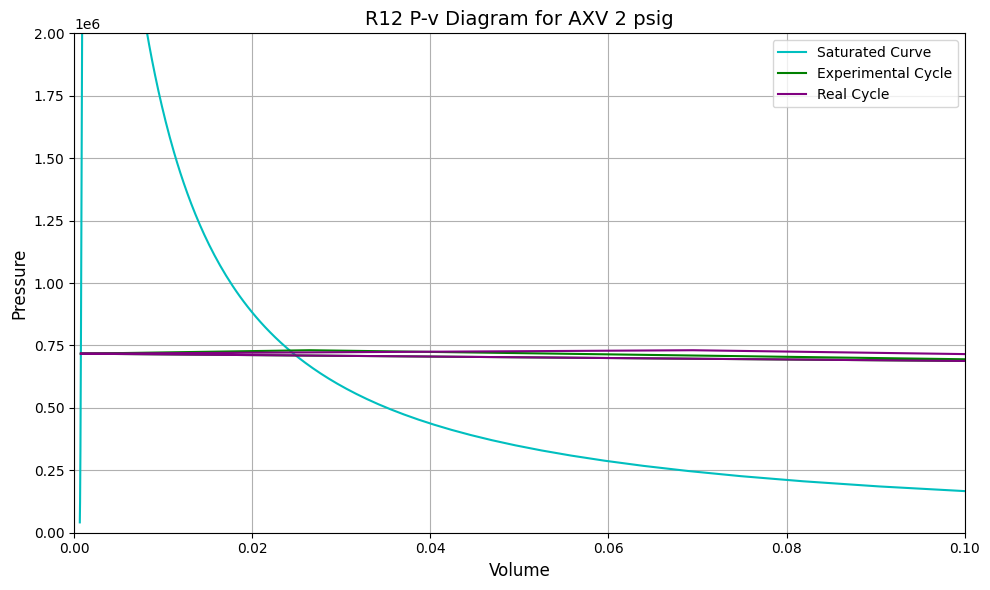

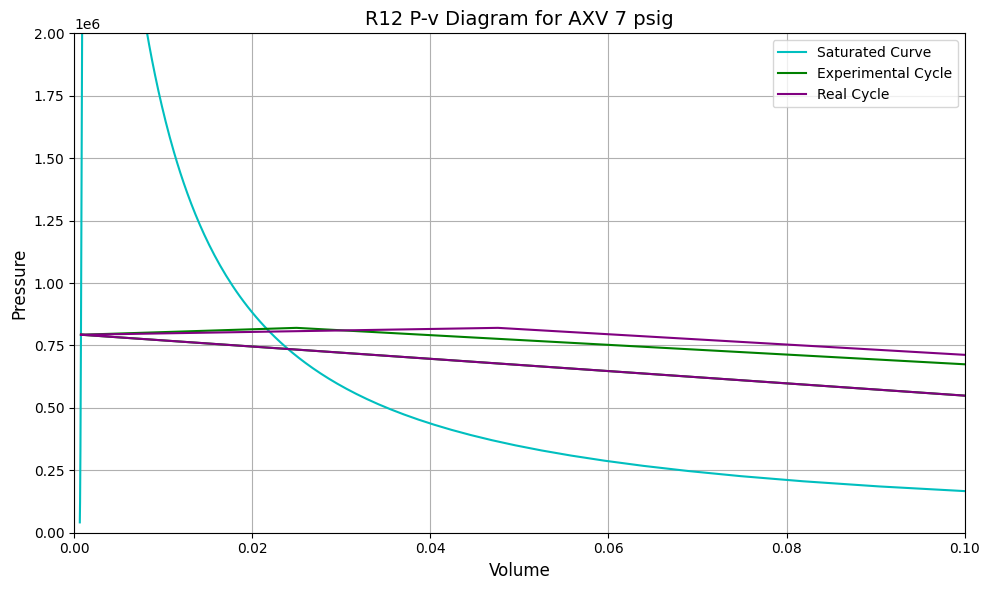

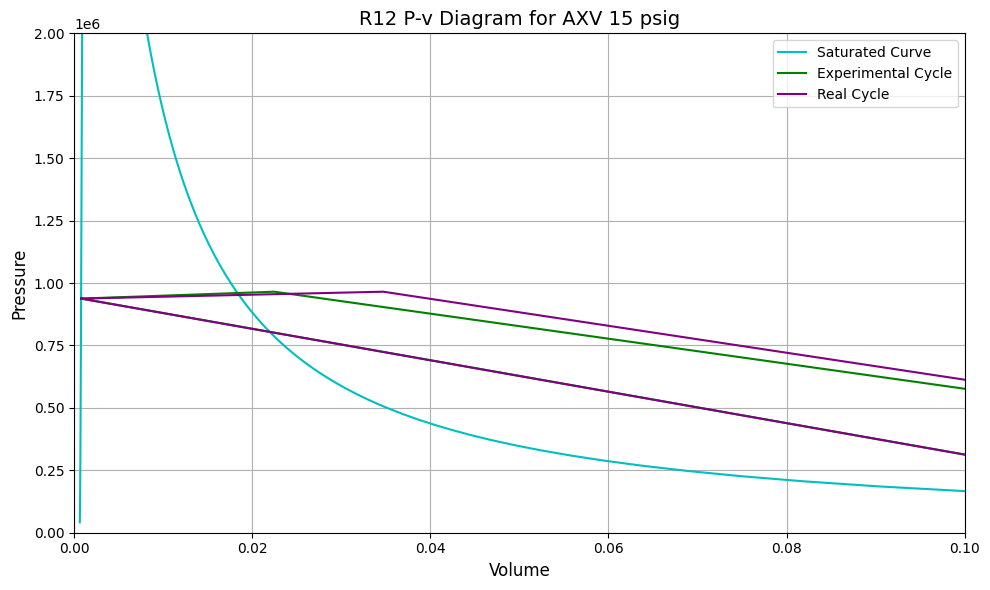

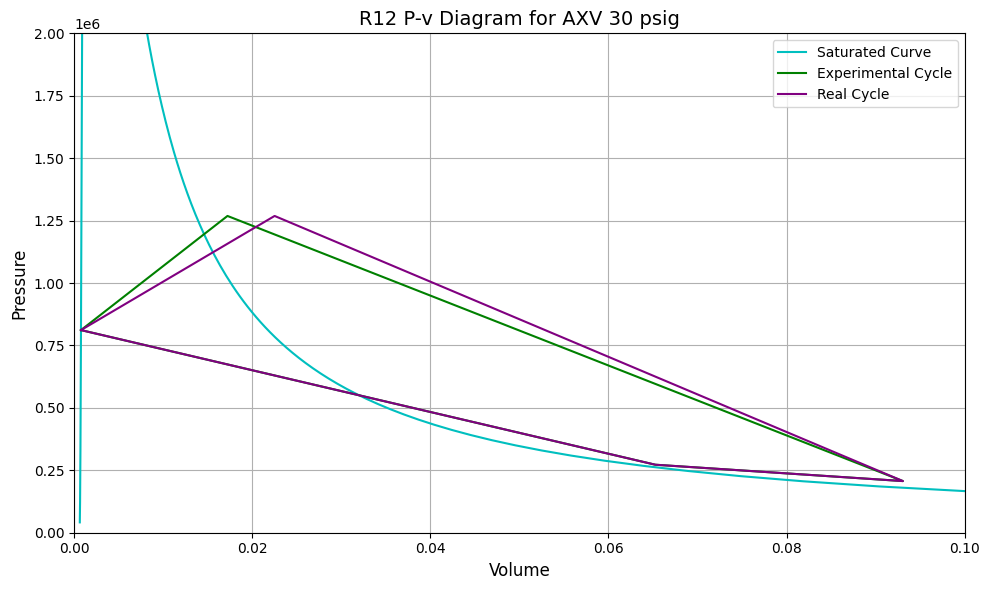

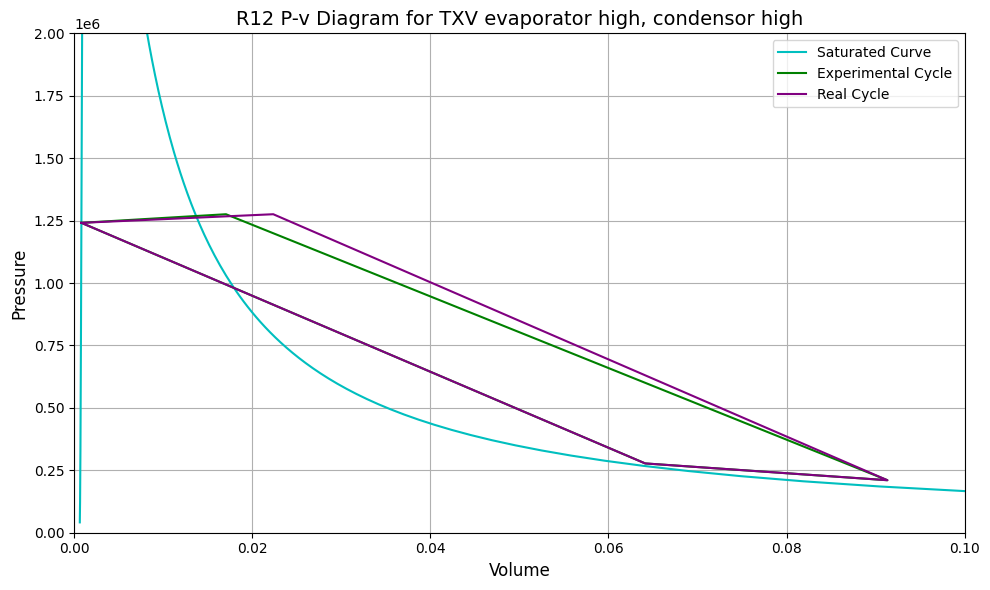

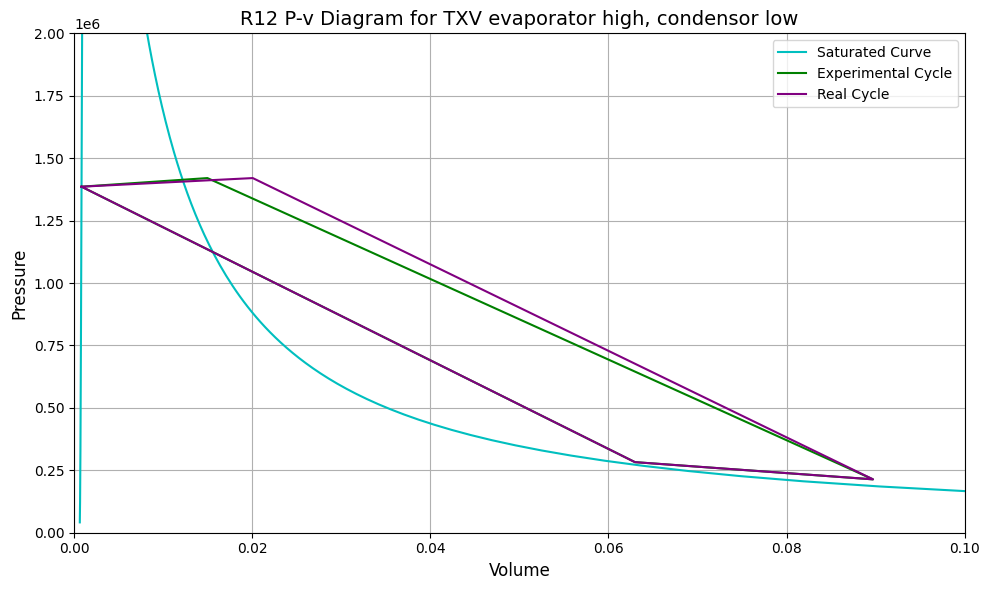

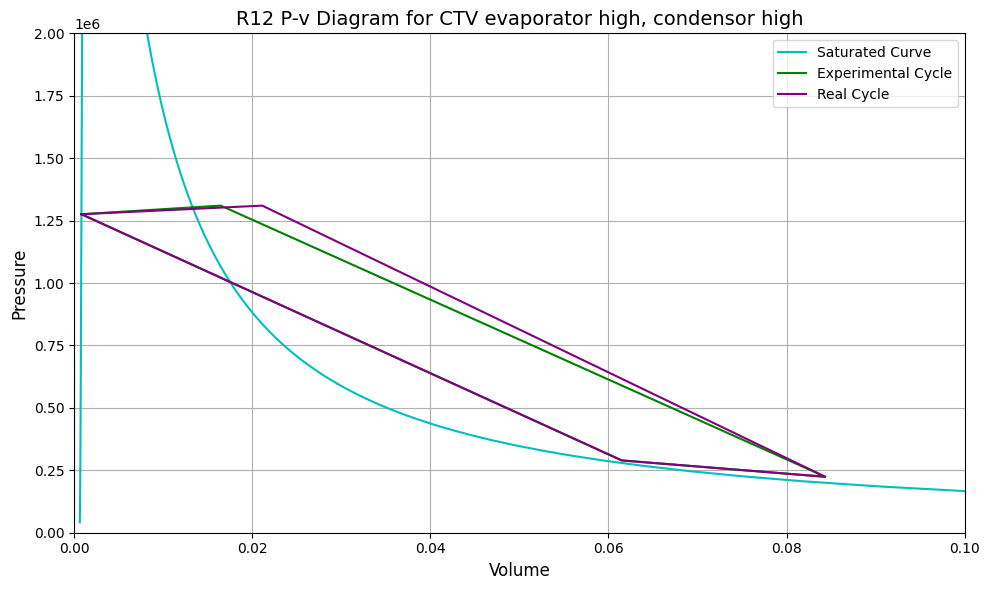

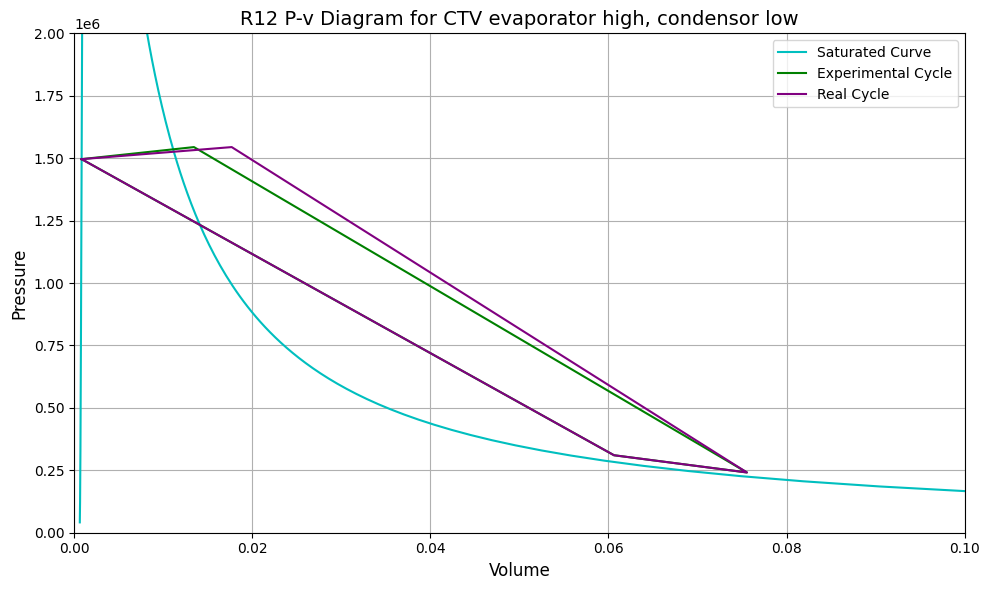

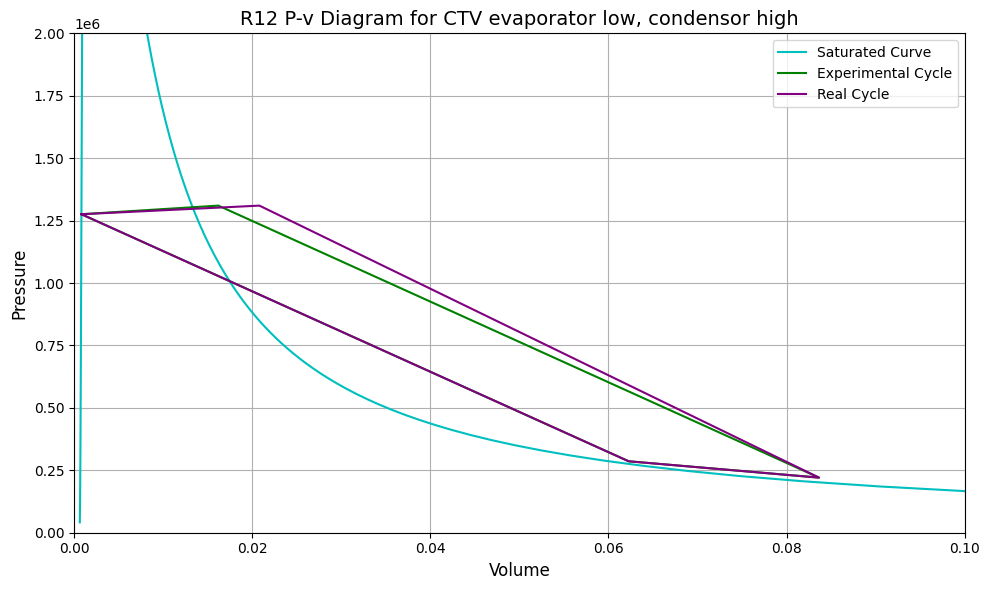

In [ ]:
#  P-V DIAGRAM

# solve for volume
v1 = []
v2 = []
v3 = []
v4 = []
v4_real = []

for p in p1:
  v1.append(1/PropsSI(  'D', 'P', p, 'Q', 0, 'R12'))
for p,T in zip(p2,T2):
  v2.append(1/PropsSI(  'D', 'P', p, 'T', T, 'R12'))
for p,T in zip(p3,T4):
  v3.append(1/PropsSI(  'D', 'P', p, 'T', T, 'R12'))
for p,T in zip(p4,T6):
  v4.append(1/PropsSI(  'D', 'P', p, 'T', T, 'R12'))
for p,T in zip(p4,T6_real):
  v4_real.append(1/PropsSI(  'D', 'P', p, 'T', T, 'R12'))

def plot_Pv_diagram(i):
  #Saturation phase dome
  pressures = np.linspace(PropsSI('Pcrit', 'R12') * 0.01, PropsSI('Pcrit', 'R12'), 200)

  # Initialize lists for temperature and entropy
  pressure_sat = []
  v_liquid = []
  v_vapor = []

  for p in pressures:
      P = PropsSI('P', 'P', p, 'Q', 0, 'R12') # pressure in Pa
      v_l = 1 / PropsSI('D', 'P', p, 'Q', 0, 'R12')  # Volume of saturated liquid
      v_v = 1 / PropsSI('D', 'P', p, 'Q', 1, 'R12')  # Volume of saturated vapor
      pressure_sat.append(P)
      v_liquid.append(v_l)
      v_vapor.append(v_v)

  volume_arr = np.array([v1[i],v2[i],v3[i],v4[i],v1[i]])
  pressure_arr = np.array([p1[i],p2[i],p3[i],p4[i],p1[i]])
  volume_real_arr = np.array([v1[i],v2[i],v3[i],v4_real[i],v1[i]])

  # make plot
  plt.figure(figsize=(10, 6))

  # Plot two-phase dome
  plt.plot(v_liquid, pressure_sat, 'c', label='Saturated Curve')
  plt.plot(v_vapor, pressure_sat, 'c')
  plt.plot(volume_arr,pressure_arr, label="Experimental Cycle", color='green')
  plt.plot(volume_real_arr,pressure_arr, label="Real Cycle", color='purple')

  # Add labels and title
  plt.title(f"R12 P-v Diagram for " + titles[i], fontsize=14)
  plt.xlabel("Volume", fontsize=12)
  plt.ylabel("Pressure", fontsize=12)
  plt.legend()
  plt.grid(True)
  plt.xlim(0, 0.1)
  plt.ylim(0, 2000000)

  # Show the plot
  plt.tight_layout()
  plt.show()


for i in range(9):
  plot_Pv_diagram(i)


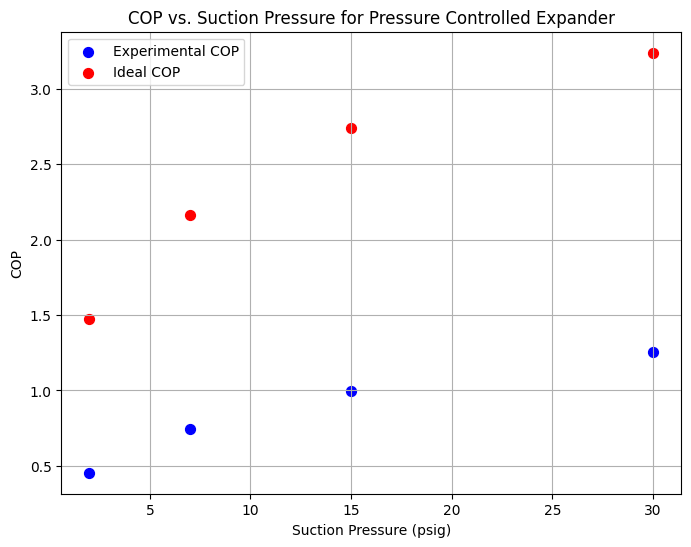

In [ ]:

suc_press = [2,7,15,30]


# Create the scatter plot
plt.figure(figsize=(8, 6))  # Adjust figure size if needed
plt.scatter(suc_press, cop_real[:4], label='Experimental COP', color='blue', marker='o', s=50) # Customize marker and size
plt.scatter(suc_press,cop_ideal[:4], label='Ideal COP', color='red', marker='o', s=50)

# Customize the plot
plt.title('COP vs. Suction Pressure for Pressure Controlled Expander')
plt.xlabel('Suction Pressure (psig)')
plt.ylabel('COP')
plt.legend()
plt.grid(True)


# Show the plot
plt.show()